### Stage 2: Business Data Storytelling

In this notebook we load two stocks and performs a RSI and Moving Average analysis on them. 
Then we explore the engineered data in order to see if the new generated parameters, can widen our understandig of the data. We will do this by plotting the engineered data in a graph, and use it for analysing when to buy and sell the stocks. If the outcome of these analysis is not useful, it indicates that we should use more complex methods for prediction or combine these analysis with other types of data engineering for use in AI models. 

In [8]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

1) First we load in the stock information and extract the open, high, low and closing price.

2) Then we clean the data by removing nan values

3) Afterwards we plot the graph to get a overview of the price evolution. 

nr. 0/1


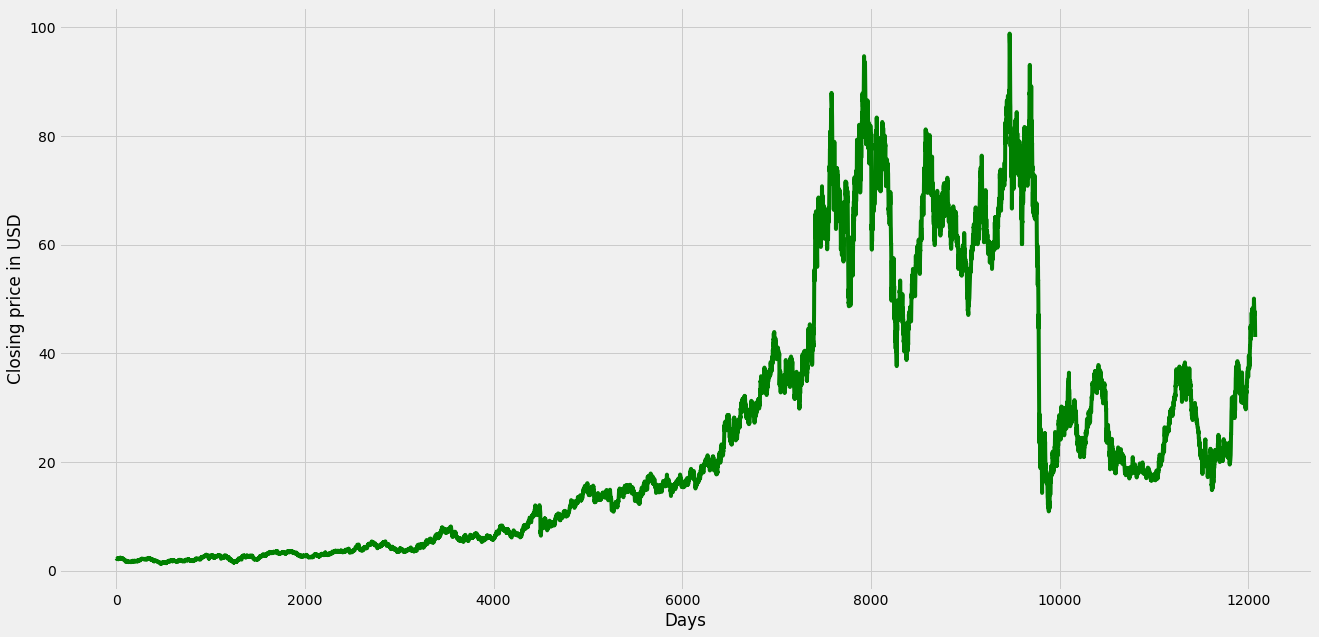

In [9]:
path = r"./data/stocks/"
files = listdir(path)# many crypto 

for indx, file in enumerate(files[1:2]):
    print("nr. "+str(indx) +"/"+ str(len(files[1:2])))
    indx = 2
    dataset = pd.DataFrame()
    dataset = pd.read_csv(path + file)
    
    if len(dataset) < 800 and indx != 0:
        print("Dataset smaller then 800 skipping ...")
        continue
        
    dataset["Open"] = dataset["Open"].astype(float)
    dataset["High"] = dataset["High"].astype(float)
    dataset["Low"] = dataset["Low"].astype(float)
    dataset["Close"] = dataset["Close"].astype(float)
    dataset = dataset.reset_index()
    dataset = dataset.dropna()
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20, 10))
    plt.xlabel("Days")
    plt.ylabel("Closing price in USD")
    plt.plot(dataset["Close"],color='g', label='close price')
    plt.show()

The graph above shows the closing price over 12.000 days.

Then we performs a RSI, 30 day moving average and a 140 day moving average analysis on the stock. 
As the 140 day moving average starts 140 rows into the dataset, it therefore has 140 nan values, that we remove after performing the analysis 

In [10]:
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod=20)
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window=30).mean()
dataset['140day MA'] = dataset['Close'].shift(1).rolling(window=140).mean()
dataset.dropna(inplace=True)

By plotting the closing price with the RSI and moving average below we can explore our data further

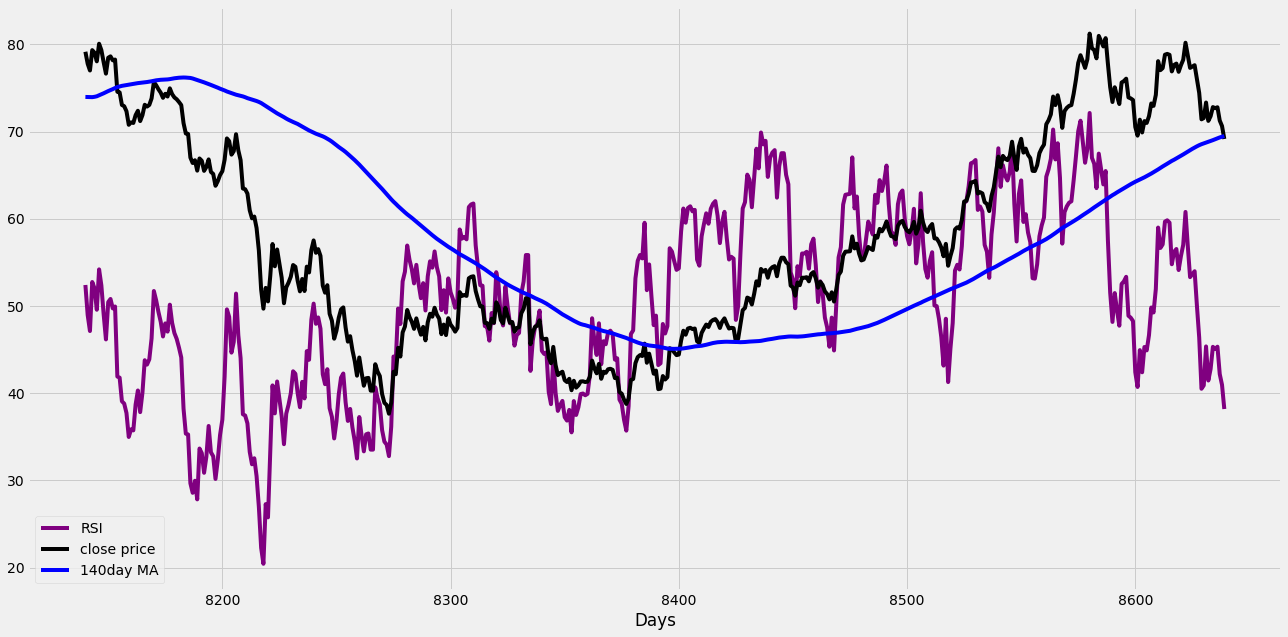

In [16]:
dataset_sample = dataset[8000:8500]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(dataset_sample["RSI"],color='purple', label='RSI')
plt.plot(dataset_sample["Close"],color='black', label='close price')
plt.plot(dataset_sample["140day MA"],color='b', label='140day MA')
plt.xlabel("Days")
plt.legend()
plt.show()

The y axis on this graph represents the price in USD for both moving average and the closing price for the stock. For the RSI analysis the y axis represents an index from 0-100. Which indicates if the stock is overbought or oversold depending if it's close to 0 or close to 100.

- If the RSI is below 30 its oversold and it indicates when to buy. 

- If the RSI is above 70 its overbought and it indicates when to sell. 

Below we use the RSI and moving average to perform predictions of when to buy and sell.

We have implemented two types of predictions one, using both moving average on 140 days and RSI and one using only moving average on 30 and 140 days.

In [17]:
#moving average with RSI
# dataset["buy"] = np.where(((dataset["RSI"]< 40 )),1,0) # & (dataset["140day MA"]<dataset["Close"])
# dataset["sell"] = np.where(((dataset["RSI"]> 70 ) | (dataset["140day MA"]>dataset["Close"])),1,0) 

#double moving average
dataset["buy"] = np.where((dataset["140day MA"]<dataset["Close"]) & (dataset["30day MA"]<dataset["Close"] ),1,0)
dataset["sell"] = np.where((dataset["140day MA"]>dataset["Close"]) | (dataset["30day MA"]>dataset["Close"] ),1,0)

In [18]:
dataset["buy"] = np.where((dataset["buy"] == 1) &
                                  (dataset["buy"].shift(1) == 0), 1, 0)

dataset["buy_spot"] = np.where(
  (dataset["buy"] == 1), dataset["Close"], 0)

dataset["sell"] = np.where((dataset['sell'] == 1) &
                                (dataset['sell'].shift(1) == 0), 1, 0)

dataset["sell_spot"] = np.where(
  (dataset["sell"] == 1), dataset["Close"], 0)

Then we take a close up look at the predictions, by looking at a small sample of the data with predictions.


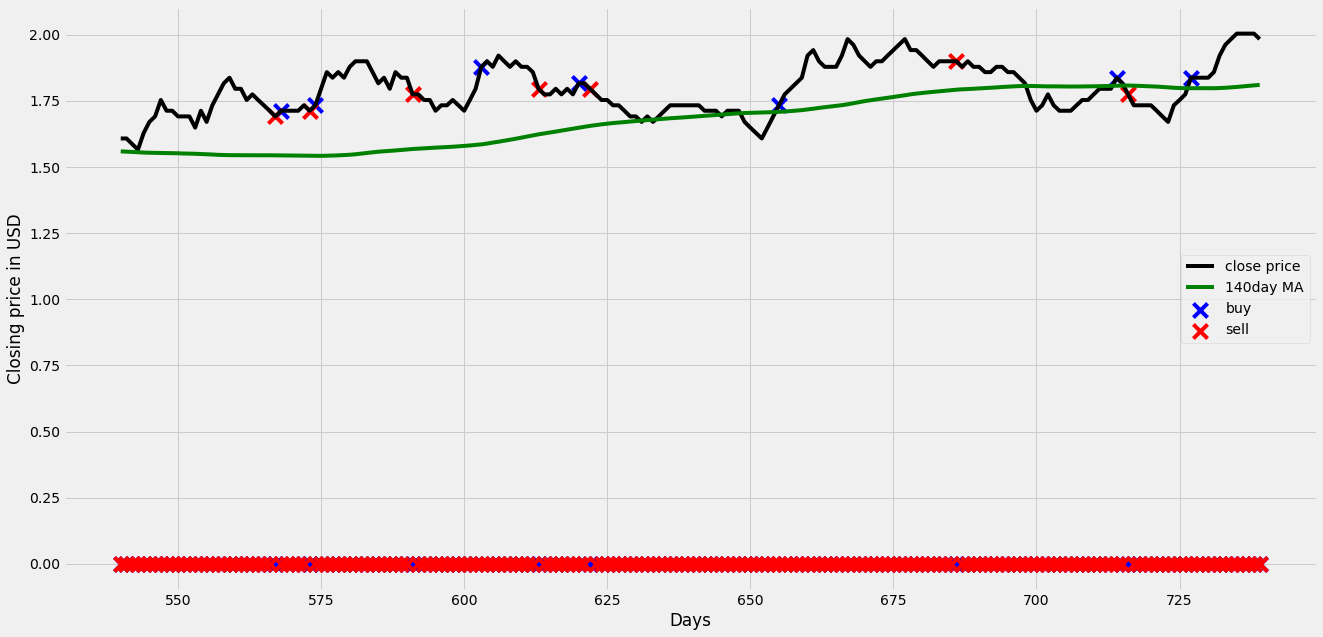

In [19]:
dataset_sample = dataset[400:600]

plt.figure(figsize=(20, 10))
plt.plot(dataset_sample["Close"],color='black', label='close price')
# plt.plot(dataset_sample["RSI"],color='purple', label='30day MA')
plt.plot(dataset_sample["140day MA"],color='g', label='140day MA')
plt.scatter(dataset_sample.index,dataset_sample["buy_spot"],color='b', label='buy', marker="x",s=200)
plt.scatter(dataset_sample.index,dataset_sample["sell_spot"],color='r', label='sell', marker="x",s=200)
plt.xlabel("Days")
plt.ylabel("Closing price in USD")
plt.legend()
plt.show()

Below we calculate what the profit, of using our predictions, would be. 

In [20]:
dataset['Tomorrows Returns'] = 0.
dataset['Tomorrows Returns'] = dataset['Close'].shift(-1) - dataset['Close'] 

In [21]:
own = False
own_days = []
accumulated_market_return = 0
accumulated_stradegy_return = 0

for indx, row in dataset.iterrows():
    if row["buy_spot"] != 0:
        own = True
    if row["sell_spot"] != 0:
        own = False
    own_days.append(own)   
      
dataset["own"] = own_days

In [22]:
dataset['Strategy Returns'] = 0.
dataset['Strategy Returns'] = np.where(dataset['own'] == True, dataset['Tomorrows Returns'], 0)

dataset['Cumulative Market Returns'] = np.cumsum(dataset['Tomorrows Returns'])
dataset['Cumulative Strategy Returns'] = np.cumsum(dataset['Strategy Returns'])

dataset["buy"] = np.where((dataset['own'] == True) & (dataset['own'].shift(1) == False), 1, 0)

In [23]:
dataset

,index,Date,Open,High,Low,Close,Volume,OpenInt,RSI,30day MA,140day MA,buy,sell,buy_spot,sell_spot,Tomorrows Returns,own,Strategy Returns,Cumulative Market Returns,Cumulative Strategy Returns
140,140,1970-07-22,1.5868,1.6079,1.5868,1.5868,51727,0,40.009619,1.647960,2.022735,0,0,0.0,0.0,0.0211,False,0.0,0.0211,0.0000
141,141,1970-07-23,1.5868,1.6079,1.5655,1.6079,310356,0,42.558061,1.643077,2.017661,0,0,0.0,0.0,-0.0211,False,0.0,0.0000,0.0000
142,142,1970-07-24,1.6079,1.6079,1.5868,1.5868,45979,0,40.736462,1.639583,2.012889,0,0,0.0,0.0,0.0000,False,0.0,0.0000,0.0000
143,143,1970-07-27,1.5868,1.5868,1.5655,1.5868,67818,0,40.736462,1.638197,2.008265,0,0,0.0,0.0,0.0000,False,0.0,0.0000,0.0000
144,144,1970-07-28,1.5868,1.5868,1.5868,1.5868,63221,0,40.736462,1.636127,2.003641,0,0,0.0,0.0,0.0211,False,0.0,0.0211,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12069,12069,2017-11-06,47.2000,47.6800,46.5300,47.2900,1725638,0,53.650268,47.461667,38.538286,0,0,0.0,0.0,-0.3200,False,0.0,45.3832,19.4377
12070,12070,2017-11-07,47.1100,47.2042,46.5400,46.9700,2168351,0,52.109366,47.528333,38.652500,0,0,0.0,0.0,-1.0800,False,0.0,44.3032,19.4377
12071,12071,2017-11-08,46.7300,46.7700,45.3700,45.8900,3347930,0,47.284634,47.602667,38.759143,0,0,0.0,0.0,-2.5600,False,0.0,41.7432,19.4377
12072,12072,2017-11-09,44.7100,44.7100,43.1100,43.3300,7671810,0,38.410931,47.630000,38.860500,0,0,0.0,0.0,-0.3200,False,0.0,41.4232,19.4377


Finally we look at a close-up of the outcome of our predictions compared to the marked return of holding the stock.

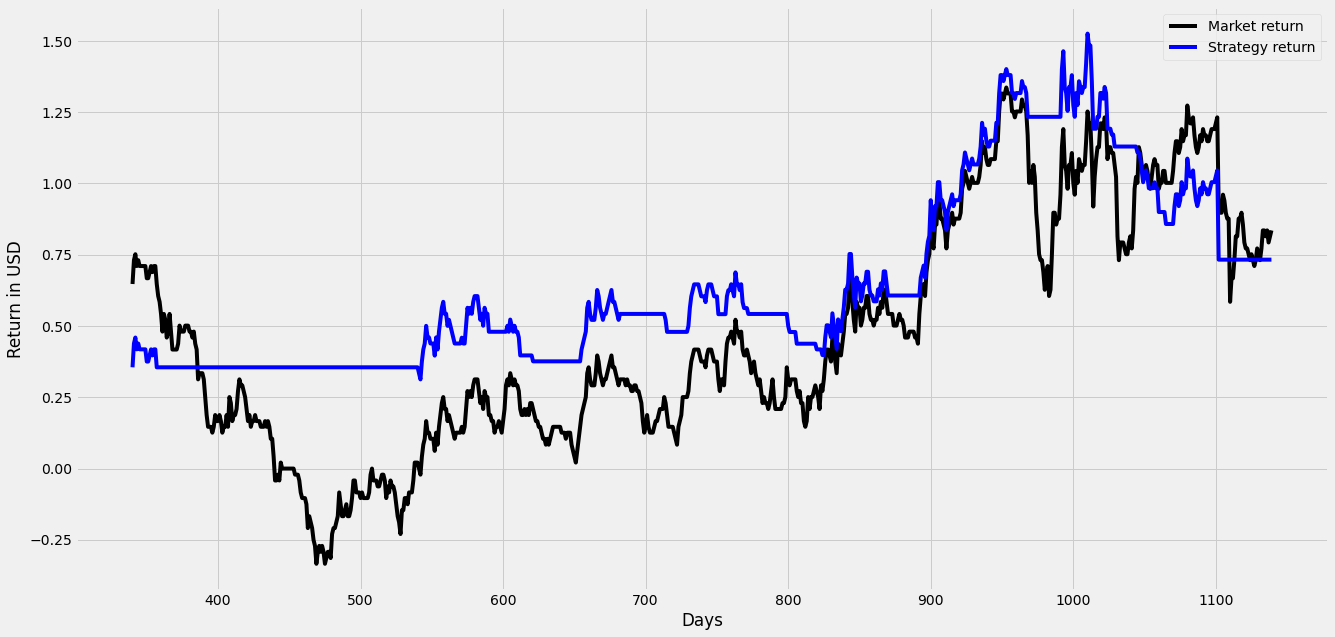

In [35]:
dataset_sample = dataset
dataset_sample = dataset[200:1000]
plt.figure(figsize=(20, 10))
plt.plot(dataset_sample["Cumulative Market Returns"],color='black', label='Market return')
plt.plot(dataset_sample["Cumulative Strategy Returns"],color='b', label='Strategy return')
plt.xlabel("Days")
plt.ylabel("Return in USD")
plt.legend()
plt.show()

In [34]:
print("The total accumilated Market return is: ", dataset["Cumulative Market Returns"].iloc[-2])
print("The total accumilated Strategy return is: ", dataset["Cumulative Strategy Returns"].iloc[-2])

The total accumilated Market return is:  41.4232
The total accumilated Strategy return is:  19.437700000000028
